# This notebook is used to extract video clips from the raw video data to opensource our data, and only needed to run if no opensoursed video clips is available.
The raw video data not only containes privacy data that is forbidden to be shared by the approved ethics, but also has lots of redundent data where no any event of interest is happened. Therefore, to remove identification information and reduce the data size, we extract video clips that including passing events from the raw video data and opensource the extracted video clips for public use.

All raw trip videos and manually labelled data of passing event and button-press event are saved on a S:Drive of Monash University and managered by the Primary Chief Investigator (PCI) of the project Prof. Ben Beck (https://research.monash.edu/en/persons/ben-beck). Therefore, in order to get access to these data and run this notebook, you need to contact Prof. Ben Beck to ask for access to the data.

Note: 
* To map the S:Drive to your computer, please follow https://www.monash.edu/esolutions/data-storage/how-to-map-s-drive.
* After mapping to the S:Drive, you can find the manually labelled data `S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MJ` and the raw videos in folders with name `MPDS_{ParticipantId}_MB{MetroBoxId}`.



In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
import subprocess
import cv2

## Read manually labelled data
These files are saved in `S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MJ`, where
* MJ_ButtonPressData_20220401.xlsx: saves all related information where a cyclist pressed the button
* MJ_PassingDistanceData_20220401.xls: saves all related information when a passing happened

In [2]:
root_dir = r"S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MJ"

In [3]:
Pass_df = pd.read_excel(os.path.join(root_dir, 'MJ_PassingDistanceData_20220401.xls'))
Press_df = pd.read_excel(os.path.join(root_dir, 'MJ_ButtonPressData_20220401.xlsx'))

In [10]:
print('Pass_df shape: {}'.format(Pass_df.shape))
Pass_df.head()

Pass_df shape: (18527, 22)


,pass_id,riderid,tripnumber,videofile,frameminutes,milliseconds,passdistance,buttonpress,timestamp,latitude,...,location_coded,bikelane_coded,parkedcar_coded,eventtype_coded,sign_speed,miss_signspeed,passdistance_coded,passdistance_1m,speedzone_coded,speedzone_collapsed
0,322,1,1,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,0:0:12.768,3187733,127.0,NaN,NaN,NaN,...,MidBlock,No,Yes,Pass,NaN,1,120-149,>=100cm,NaN,NaN
1,225,1,1,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,0:0:13.710,1065833,152.0,NaN,2017-04-10T22:07:43Z,-37.909447,...,MidBlock,Yes,No,Pass,60.0,0,150-199,>=100cm,<=60 km/h,60km/h
2,226,1,1,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,0:0:26.818,1078933,189.0,NaN,2017-04-10T22:07:57Z,-37.908642,...,MidBlock,Yes,Yes,Pass,60.0,0,150-199,>=100cm,<=60 km/h,60km/h
3,227,1,1,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,0:0:31.21,1083133,140.0,NaN,2017-04-10T22:08:01Z,-37.908405,...,MidBlock,Yes,No,Pass,60.0,0,120-149,>=100cm,<=60 km/h,60km/h
4,323,1,1,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,0:0:38.385,3213333,140.0,NaN,NaN,NaN,...,MidBlock,No,Yes,Pass,NaN,1,120-149,>=100cm,NaN,NaN


In [9]:
print('Press_df shape: {}'.format(Press_df.shape))
Press_df.head()

Press_df shape: (224, 17)


,MP_Mannual review of button press footage,RiderId,TripNumber,EventType,VideoFile,FrameMinutes,MilliSeconds,PassDistance,ButtonPress,VehicleType,Location,BikeLane,ParkedCar,Review,timestamp,latitude,longitude
0,correct,1,1,Pass,C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1...,00:11:23,2796433,69.0,Yes,Truck,MidBlock,No,Yes,NaN,NaN,NaN,NaN
1,correct,5,3,Pass,C:\Users\mper0013\Desktop\Desktop_Data\Trip_3_...,00:16:05.760000,950632,51.5,Yes,Bus,MidBlock,Yes,No,NaN,2017-04-23T23:28:52Z,-37.810144,144.969344
2,Correct,7,1,Pass,C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_...,00:01:22.751000,74491,66.0,Yes,Sedan,MidBlock,Yes,Yes,NaN,2017-04-26T07:44:54Z,-37.848510,144.980248
3,Correct,7,1,Pass,C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_...,00:03:34.939000,206591,71.0,Yes,Sedan,MidBlock,No,No,NaN,2017-04-26T07:47:07Z,-37.850776,144.985172
4,Correct,7,8,Pass,C:\Users\mper0013\Desktop\Desktop_Data\Trip_8_...,00:05:24.857000,3499711,75.0,Yes,Sedan,MidBlock,No,No,NaN,2017-04-30T23:40:54Z,-37.814260,144.971480


## Statistics of Raw Video Data
Iterate through all raw videos and see how many videos are there and how big is the raw video data.

In [11]:
# Note: the S:drive is shared by Ben and only approved users have acceess for privacy concerns.
cyc_raw_data_path = r"S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data"

cyc_video_folder_list = []
for cyc_raw_data_folder in os.listdir(cyc_raw_data_path):
    if 'MPDS_' in cyc_raw_data_folder and os.path.isdir(os.path.join(cyc_raw_data_path, cyc_raw_data_folder)):
        cyc_video_folder_list.append(cyc_raw_data_folder)

In [12]:
all_video_list = []
all_video_dict = {}
for cyc_video_folder in cyc_video_folder_list:
    print(cyc_video_folder)
    for tmp_folder in os.listdir(os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox')):
        if 'Trip_' in tmp_folder:
            print('\t{}'.format(tmp_folder))
            # All videos are saved in Trip_x_Input
            tmp_folder_inner = '{}_Input'.format(tmp_folder.split('_O')[0])
            print('\t\t{}'.format(tmp_folder_inner))
            tmp_video_folder = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', tmp_folder, tmp_folder_inner)
            for file in os.listdir(tmp_video_folder):
                print('\t\t\t{}'.format(file))
                if os.path.isdir(os.path.join(tmp_video_folder,file)):
                    # There is a case with nested Trip_x_Input: MPDS_057_MB4\MetreBox\Trip_4_Output\Trip_4_Input\Trip_4_Input
                    for inner_file in os.listdir(os.path.join(tmp_video_folder,file)):
                        print('\t\t\t\t{}'.format(inner_file))
                        if '.LRV' in inner_file:
                            video_folder_name = '_'.join(cyc_video_folder.split('-')[0].split('_')[:2])
                            video_file_name = inner_file
                            video_unique_id = '/'.join([video_folder_name, video_file_name])
                            all_video_list.append('-'.join([cyc_video_folder, 'MetreBox', tmp_folder, tmp_folder_inner, file, inner_file]))
                            all_video_dict[video_unique_id] = [cyc_video_folder, 'MetreBox', tmp_folder, tmp_folder_inner, file, inner_file]
                else:
                    if '.LRV' in file:
                        all_video_list.append('-'.join([cyc_video_folder, 'MetreBox', tmp_folder, tmp_folder_inner, file]))
                        video_folder_name = '_'.join(cyc_video_folder.split('-')[0].split('_')[:2])
                        video_file_name = file
                        video_unique_id = '/'.join([video_folder_name, video_file_name])
                        all_video_dict[video_unique_id] = [cyc_video_folder, 'MetreBox', tmp_folder, tmp_folder_inner, file]

MPDS_001_MB5
	Trip_1_Output
		Trip_1_Input
			02.CSV
			Trip_1.0_GOPR0006.LRV
			Trip_1.1_GP010006.LRV
			Trip_1.2_GP020006.LRV
			Trip_1.3_GP030006.LRV
			Trip_1.4_GP040006.LRV
	Trip_2_Output
		Trip_2_Input
			03.CSV
			Trip_2.0_GOPR0007.LRV
			Trip_2.1_GP010007.LRV
			Trip_2.2_GP020007.LRV
			Trip_2.3_GP030007.LRV
			Trip_2.4_GP040007.LRV
	Trip_3_Output
		Trip_3_Input
			06.CSV
			Trip_3.0_GOPR0008.LRV
			Trip_3.1_GP010008.LRV
			Trip_3.2_GP020008.LRV
			Trip_3.3_GP030008.LRV
			Trip_3.4_GP040008.LRV
	Trip_4_Output
		Trip_4_Input
			08.CSV
			Trip_4.0_GOPR0009.LRV
			Trip_4.1_GP010009.LRV
			Trip_4.2_GP020009.LRV
			Trip_4.3_GP030009.LRV
			Trip_4.4_GP040009.LRV
	Trip_5_Output
		Trip_5_Input
			10.CSV
			Trip_5.0_GOPR0010.LRV
			Trip_5.1_GP010010.LRV
			Trip_5.2_GP020010.LRV
MPDS_002_MB4
	Trip_1_Output
		Trip_1_Input
			01.CSV
			Trip_1.0_GOPR0002.LRV
	Trip_2_Output
		Trip_2_Input
			02.CSV
			Trip_2.0_GOPR0003.LRV
			Trip_2.1_GP010003.LRV
			Trip_2.2_GP020003.LRV
	Trip_3_Output
		Tr

			Trip_7.0_GOPR2889.LRV
			Trip_7.1_GP012889.LRV
	Trip_8_Output_No_CSV
		Trip_8_Input
			Trip_8.0_GOPR2890.LRV
			Trip_8.1_GP012890.LRV
	Trip_9_Output_No_CSV
		Trip_9_Input
			Trip_9.0_GOPR2891.LRV
			Trip_9.1_GP012891.LRV
			Trip_9.2_GP022891.LRV
			Trip_9.3_GP032891.LRV
			Trip_9.4_GP042891.LRV
			Trip_9.5_GP052891.LRV
MPDS_011_MB1
	Trip_10_Output
		Trip_10_Input
			13.CSV
			Trip_10.0_GOPR2425.LRV
			Trip_10.1_GP012425.LRV
			Trip_10.2_GP022425.LRV
	Trip_11_Output
		Trip_11_Input
			14.CSV
			Trip_11.0_GOPR2426.LRV
			Trip_11.1_GP012426.LRV
	Trip_12_Output
		Trip_12_Input
			15.CSV
			Trip_12.0_GOPR2427.LRV
			Trip_12.1_GP012427.LRV
	Trip_1_Output
		Trip_1_Input
			03.CSV
			Trip_1.0_GOPR2416.LRV
			Trip_1.1_GP012416.LRV
	Trip_2_Output
		Trip_2_Input
			05.CSV
			Trip_2.0_GOPR2417.LRV
			Trip_2.1_GP012417.LRV
			Trip_2.2_GP022417.LRV
	Trip_3_Output
		Trip_3_Input
			06.CSV
			Trip_3.0_GOPR2418.LRV
			Trip_3.1_GP012418.LRV
	Trip_4_Output
		Trip_4_Input
			07.CSV
			Trip_4.0_GOPR2419

	Trip_1_Output
		Trip_1_Input
			03.CSV
			Trip_1.0_GOPR0010.LRV
			Trip_1.1_GP010010.LRV
			Trip_1.2_GP020010.LRV
	Trip_2_Output
		Trip_2_Input
			04.CSV
			Trip_2.0_GOPR0011.LRV
			Trip_2.1_GP010011.LRV
	Trip_3_Output
		Trip_3_Input
			05.CSV
			Trip_3.0_GOPR0012.LRV
			Trip_3.1_GP010012.LRV
	Trip_4_Output
		Trip_4_Input
			06.CSV
			Trip_4.0_GOPR0013.LRV
			Trip_4.1_GP010013.LRV
	Trip_5_Output
		Trip_5_Input
			07.CSV
			Trip_5.0_GOPR0014.LRV
			Trip_5.1_GP010014.LRV
			Trip_5.2_GP020014.LRV
	Trip_6_Output
		Trip_6_Input
			08.CSV
			Trip_6.0_GOPR0015.LRV
			Trip_6.1_GP010015.LRV
	Trip_7_Output
		Trip_7_Input
			09.CSV
			Trip_7.0_GOPR0016.LRV
			Trip_7.1_.LRV
			Trip_7.2_GP020016.LRV
	Trip_8_Output
		Trip_8_Input
			10.CSV
			Trip_8.0_GOPR0017.LRV
			Trip_8.1_GP010017.LRV
			Trip_8.2_GP020017.LRV
MPDS_023_MB6
	Trip_1_Output
		Trip_1_Input
			02.CSV
			Trip_1.0_GOPR0002.LRV
			Trip_1.1_GP010002.LRV
			Trip_1.2_GP020002.LRV
	Trip_2_Output
		Trip_2_Input
			03.CSV
			Trip_2.0_GOPR0003

			03.CSV
			Trip_1.0_GOPR3862.LRV
			Trip_1.1_GP013862.LRV
			Trip_1.2_GP023862.LRV
	Trip_2_Output
		Trip_2_Input
			04.CSV
			Trip_2.0_GOPR3863.LRV
			Trip_2.1_GP013863.LRV
			Trip_2.2_GP023863.LRV
			Trip_2.3_GP033863.LRV
	Trip_3_Output
		Trip_3_Input
			05.CSV
			Trip_3.0_GOPR3864.LRV
	Trip_4_Output
		Trip_4_Input
			07.CSV
			Trip_4.0_GOPR3865.LRV
			Trip_4.1_GP013865.LRV
	Trip_5_Output
		Trip_5_Input
			08.CSV
			Trip_5.0_GOPR3968.LRV
			Trip_5.1_GP013968.LRV
			Trip_5.2_GP023968.LRV
			Trip_5.3_GP033968.LRV
MPDS_035_MB8
	Trip_1_Output
		Trip_1_Input
			02.CSV
			Trip_1.0_GOPR5619.LRV
			Trip_1.1_GP015619.LRV
			Trip_1.2_GP025619.LRV
	Trip_2_Output
		Trip_2_Input
			03.CSV
			Trip_2.0_GOPR6153.LRV
	Trip_3_Output
		Trip_3_Input
			04.CSV
			Trip_3.0_GOPR6295.LRV
			Trip_3.1_GP016295.LRV
			Trip_3.2_GP026295.LRV
	Trip_4_Output
		Trip_4_Input
			05.CSV
			Trip_4.0_GOPR6846.LRV
			Trip_4.1_GP016846.LRV
			Trip_4.2_GP026846.LRV
	Trip_5_Output
		Trip_5_Input
			06.CSV
			Trip_5.0_GOPR7

			06.CSV
			Trip_3.0_GOPR0357.LRV
	Trip_4_Output
		Trip_4_Input
			07.CSV
			Trip_4.0_GOPR0463.LRV
			Trip_4.1_GP010463.LRV
	Trip_5_Output
		Trip_5_Input
			08.CSV
			Trip_5.0_GOPR0890.LRV
			Trip_5.1_GP010890.LRV
	Trip_6_Output
		Trip_6_Input
			09.CSV
			Trip_6.0_GOPR1280.LRV
			Trip_6.1_GP011280.LRV
			Trip_6.2_GP021280.LRV
MPDS_044_MB9
	Trip_1_Output
		Trip_1_Input
			02.CSV
			Trip_1.0_GOPR3970.LRV
			Trip_1.1_GP013970.LRV
	Trip_2_Output
		Trip_2_Input
			03.CSV
			Trip_2.0_GOPR3971.LRV
			Trip_2.1_GP013971.LRV
	Trip_3_Output
		Trip_3_Input
			04.CSV
			Trip_3.0_GOPR3972.LRV
			Trip_3.1_GP013972.LRV
	Trip_4_Output
		Trip_4_Input
			05.CSV
			Trip_4.0_GOPR3973.LRV
			Trip_4.1_GP013973.LRV
			Trip_4.2_GP023973.LRV
	Trip_5_Output
		Trip_5_Input
			06.CSV
			Trip_5.0_GOPR3974.LRV
			Trip_5.1_GP013974.LRV
	Trip_6_Output
		Trip_6_Input
			07.CSV
			Trip_6.0_GOPR3975.LRV
			Trip_6.1_GP013975.LRV
	Trip_7_Output
		Trip_7_Input
			08.CSV
			Trip_7.0_GOPR3976.LRV
			Trip_7.1_GP013976.LRV
	T

			Trip_4.0_GOPR0048.LRV
	Trip_5_Output
		Trip_5_Input
			10.CSV
			Trip_5.0_GOPR0049.LRV
	Trip_6_Output
		Trip_6_Input
			11.CSV
			Trip_6.0_GOPR0050.LRV
	Trip_7_Output_CSV_empty
		Trip_7_Input
			12.CSV
			Trip_7.0_GOPR0051.LRV
			Trip_7.1_GP010051.LRV
	Trip_8_Output_CSV_empty
		Trip_8_Input
			13.CSV
			Trip_8.0_GOPR0052.LRV
	Trip_9_Output_CSV_empty
		Trip_9_Input
			14.CSV
			Trip_9.0_GOPR0055.LRV
MPDS_055_MB2
	Trip_10_Output
		Trip_10_Input
			11.CSV
			Trip_10.0_GOPR2160.LRV
			Trip_10.1_GP012160.LRV
	Trip_11_Output
		Trip_11_Input
			12.CSV
			Trip_11.0_GOPR2161.LRV
			Trip_11.1_GP012161.LRV
	Trip_12_Output
		Trip_12_Input
			13.CSV
			Trip_12.0_GOPR2162.LRV
			Trip_12.1_GP012162.LRV
	Trip_1_Output
		Trip_1_Input
			03.CSV
			Trip_1.0_GOPR2151.LRV
			Trip_1.1_GP012151.LRV
			Trip_1.2_GP022151.LRV
	Trip_2_Output
		Trip_2_Input
			04.CSV
			Trip_2.0_GOPR2152.LRV
	Trip_3_Output_No_CSV
		Trip_3_Input
			Trip_3.0_GP012152.LRV
			Trip_3.1_GP022152.LRV
	Trip_4_Output_CSV_Empty
		Trip_4

			Trip_3.0_GOPR0058.LRV
			Trip_3.1_GP010058.LRV
			Trip_3.2_GP020058.LRV
	Trip_4_Output
		Trip_4_Input
			06.CSV
			Trip_4.0_GOPR0059.LRV
			Trip_4.1_GP010059.LRV
			Trip_4.2_GP020059.LRV
			Trip_4.3_GP030059.LRV
	Trip_5_Output
		Trip_5_Input
			07.CSV
			Trip_5.0_GOPR0060.LRV
			Trip_5.1_GP010060.LRV
			Trip_5.2_GP020060.LRV
	Trip_6_Output
		Trip_6_Input
			08.CSV
			Trip_6.0_GOPR0061.LRV
			Trip_6.1_GP010061.LRV
			Trip_6.2_GP020061.LRV
			Trip_6.3_GP030061.LRV
			Trip_6.4_GP040061.LRV
	Trip_7_Output
		Trip_7_Input
			09.CSV
			Trip_7.0_GOPR0062.LRV
			Trip_7.1_GP010062.LRV
			Trip_7.2_GP020062.LRV
			Trip_7.3_GP030062.LRV
MPDS_063_MB8
	Trip_10_Output
		Trip_10_Input
			12.CSV
			Trip_10.0_GOPR0095.LRV
			Trip_10.1_GP010095.LRV
	Trip_11_Output
		Trip_11_Input
			13.CSV
			Trip_11.0_GOPR0362.LRV
			Trip_11.1_GP010362.LRV
	Trip_12_Output
		Trip_12_Input
			14.CSV
			Trip_12.0_GOPR0667.LRV
			Trip_12.1_GP010667.LRV
	Trip_13_Output
		Trip_13_Input
			15.CSV
			Trip_13.0_GOPR0942.LRV
		

In [13]:
def convert_bytes(size):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
    return size

In [14]:
video_size_info_list = []

for tmp_video_name in all_video_dict:
    video_file_path = os.path.join(*[cyc_raw_data_path] + all_video_dict[tmp_video_name])
    video_size = os.path.getsize(video_file_path)
    print('Video Name: {}, video_size: {}'.format(tmp_video_name, convert_bytes(video_size)))
    video_size_info_list.append(video_size)
    #break

Video Name: MPDS_001/Trip_1.0_GOPR0006.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_1.1_GP010006.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_1.2_GP020006.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_1.3_GP030006.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_1.4_GP040006.LRV, video_size: 94.5 MB
Video Name: MPDS_001/Trip_2.0_GOPR0007.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_2.1_GP010007.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_2.2_GP020007.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_2.3_GP030007.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_2.4_GP040007.LRV, video_size: 188.8 MB
Video Name: MPDS_001/Trip_3.0_GOPR0008.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_3.1_GP010008.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_3.2_GP020008.LRV, video_size: 338.6 MB
Video Name: MPDS_001/Trip_3.3_GP030008.LRV, video_size: 338.5 MB
Video Name: MPDS_001/Trip_3.4_GP040008.LRV, video_size: 132.8 MB
Video Name: MPDS_001/Trip_

Video Name: MPDS_008/Trip_9.0_GOPR0023.LRV, video_size: 338.5 MB
Video Name: MPDS_008/Trip_9.1_GP010023.LRV, video_size: 199.1 MB
Video Name: MPDS_009/Trip_1.0_GOPR0102.LRV, video_size: 338.2 MB
Video Name: MPDS_009/Trip_1.1_GP010102.LRV, video_size: 135.6 MB
Video Name: MPDS_009/Trip_2.0_GOPR0103.LRV, video_size: 303.2 MB
Video Name: MPDS_009/Trip_3.0GOPR0104.LRV, video_size: 202.5 MB
Video Name: MPDS_009/Trip_4.0_GOPR0105.LRV, video_size: 338.1 MB
Video Name: MPDS_009/Trip_4.1_GP010105.LRV, video_size: 338.0 MB
Video Name: MPDS_009/Trip_4.2_GP020105.LRV, video_size: 338.2 MB
Video Name: MPDS_009/Trip_4.3_GP030105.LRV, video_size: 72.2 MB
Video Name: MPDS_009/Trip_5.0_GOPR0106.LRV, video_size: 338.1 MB
Video Name: MPDS_009/Trip_5.1_GP010106.LRV, video_size: 337.9 MB
Video Name: MPDS_009/Trip_5.2_GP020106.LRV, video_size: 338.1 MB
Video Name: MPDS_009/Trip_5.3_GP030106.LRV, video_size: 122.9 MB
Video Name: MPDS_009/Trip_6.0_GOPR0108.LRV, video_size: 338.1 MB
Video Name: MPDS_009/Trip_6

Video Name: MPDS_014/Trip_8.1_GP010024.LRV, video_size: 338.6 MB
Video Name: MPDS_014/Trip_8.2_GP020024.LRV, video_size: 224.0 MB
Video Name: MPDS_014/Trip_9.0_GOPR0025.LRV, video_size: 339.3 MB
Video Name: MPDS_014/Trip_9.1_GP010025.LRV, video_size: 338.6 MB
Video Name: MPDS_014/Trip_9.2_GP020025.LRV, video_size: 338.6 MB
Video Name: MPDS_014/Trip_9.3_GP030025.LRV, video_size: 338.8 MB
Video Name: MPDS_014/Trip_9.4GP040025.LRV, video_size: 298.3 MB
Video Name: MPDS_015/Trip_1.0_GOPR2433.LRV, video_size: 338.7 MB
Video Name: MPDS_015/Trip_1.1_GP012433.LRV, video_size: 338.6 MB
Video Name: MPDS_015/Trip_1.2_GP022433.LRV, video_size: 338.7 MB
Video Name: MPDS_015/Trip_1.3_GP032433.LRV, video_size: 338.6 MB
Video Name: MPDS_015/Trip_1.4_GP042433.LRV, video_size: 338.5 MB
Video Name: MPDS_015/Trip_1.5_GP052433.LRV, video_size: 73.6 MB
Video Name: MPDS_015/Trip_2.0_GOPR2467.LRV, video_size: 338.7 MB
Video Name: MPDS_015/Trip_2.1_GP012467.LRV, video_size: 338.6 MB
Video Name: MPDS_015/Trip_2

Video Name: MPDS_023/Trip_3.1_GP010004.LRV, video_size: 338.5 MB
Video Name: MPDS_023/Trip_3.2_GP020004.LRV, video_size: 134.1 MB
Video Name: MPDS_023/Trip_4.0_GOPR0005.LRV, video_size: 338.5 MB
Video Name: MPDS_023/Trip_4.1_GP010005.LRV, video_size: 338.5 MB
Video Name: MPDS_023/Trip_4.2_GP020005.LRV, video_size: 22.9 MB
Video Name: MPDS_024/Trip_1.0_GOPR0015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_1.1_GP010015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_1.2_GP020015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_1.3_GP030015.LRV, video_size: 338.5 MB
Video Name: MPDS_024/Trip_1.4_GP040015.LRV, video_size: 240.3 MB
Video Name: MPDS_024/Trip_2.0_GOPR1015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_2.1_GP011015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_2.2_GP021015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_2.3_GP031015.LRV, video_size: 338.5 MB
Video Name: MPDS_024/Trip_2.4_GP041015.LRV, video_size: 338.6 MB
Video Name: MPDS_024/Trip_

Video Name: MPDS_032/Trip_3.1_GP010029.LRV, video_size: 339.0 MB
Video Name: MPDS_032/Trip_3.2_GP020029.LRV, video_size: 94.5 MB
Video Name: MPDS_032/Trip_3.3_GOPR0030.LRV, video_size: 5.3 MB
Video Name: MPDS_032/Trip_4.0_GOPR0031.LRV, video_size: 339.0 MB
Video Name: MPDS_032/Trip_4.1_GP010031.LRV, video_size: 296.6 MB
Video Name: MPDS_032/Trip_5.0_GOPR0032.LRV, video_size: 339.0 MB
Video Name: MPDS_032/Trip_5.1_GP010032.LRV, video_size: 257.8 MB
Video Name: MPDS_032/Trip_6.0_GOPR0033.LRV, video_size: 339.0 MB
Video Name: MPDS_032/Trip_6.1_GP010033.LRV, video_size: 217.6 MB
Video Name: MPDS_032/Trip_7.0_GOPR0035.LRV, video_size: 283.3 MB
Video Name: MPDS_032/Trip_8.0_GOPR0036.LRV, video_size: 339.0 MB
Video Name: MPDS_032/Trip_8.1_GP010036.LRV, video_size: 192.5 MB
Video Name: MPDS_033/Trip_1.0_GOPR0008.LRV, video_size: 339.1 MB
Video Name: MPDS_033/Trip_1.1_GP010008.LRV, video_size: 216.1 MB
Video Name: MPDS_033/Trip_2.0_GOPR0009.LRV, video_size: 243.9 MB
Video Name: MPDS_033/Trip_3.

Video Name: MPDS_039/Trip_3.0_GOPR2496.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_3.1_GP012496.LRV, video_size: 338.6 MB
Video Name: MPDS_039/Trip_3.2_GP022496.LRV, video_size: 1.5 MB
Video Name: MPDS_039/Trip_4.0_GOPR2497.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_4.1_GP012497.LRV, video_size: 338.5 MB
Video Name: MPDS_039/Trip_4.2_GP022497.LRV, video_size: 5.2 MB
Video Name: MPDS_039/Trip_5.0_GOPR2498.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_5.1_GP012498.LRV, video_size: 272.6 MB
Video Name: MPDS_039/Trip_6.0_GOPR2499.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_6.1_GP012499.LRV, video_size: 2.3 MB
Video Name: MPDS_039/Trip_7.0_GOPR2500.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_7.1_GP012500.LRV, video_size: 105.8 MB
Video Name: MPDS_039/Trip_7.2_GOPR2501.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_7.3_GP012501.LRV, video_size: 205.5 MB
Video Name: MPDS_039/Trip_8.0_GOPR2502.LRV, video_size: 338.7 MB
Video Name: MPDS_039/Trip_8.1_G

Video Name: MPDS_045/Trip_5.1_GP010028.LRV, video_size: 187.1 MB
Video Name: MPDS_045/Trip_6.0_GOPR0029.LRV, video_size: 339.1 MB
Video Name: MPDS_045/Trip_7.0_GP020029.LRV, video_size: 339.1 MB
Video Name: MPDS_045/Trip_7.1_GP030029.LRV, video_size: 339.0 MB
Video Name: MPDS_045/Trip_7.2_GP040029.LRV, video_size: 283.2 MB
Video Name: MPDS_045/Trip_8.0_GOPR0030.LRV, video_size: 339.1 MB
Video Name: MPDS_045/Trip_8.1_GP010030.LRV, video_size: 101.6 MB
Video Name: MPDS_045/Trip_9.0_GOPR0031.LRV, video_size: 339.1 MB
Video Name: MPDS_045/Trip_9.1_GP010031.LRV, video_size: 143.6 MB
Video Name: MPDS_046/Trip_1.0_GOPR0069.LRV, video_size: 338.6 MB
Video Name: MPDS_046/Trip_1.1_GP010069.LRV, video_size: 338.5 MB
Video Name: MPDS_046/Trip_1.2_GP020069.LRV, video_size: 338.7 MB
Video Name: MPDS_046/Trip_1.3_GP030069.LRV, video_size: 232.5 MB
Video Name: MPDS_046/Trip_2.0_GOPR0070.LRV, video_size: 338.8 MB
Video Name: MPDS_046/Trip_2.1_GP010070.LRV, video_size: 338.6 MB
Video Name: MPDS_046/Trip

Video Name: MPDS_052/Trip_1.0_GOPR0045.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_1.1_GP010045.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_1.2_GP020045.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_1.3_GP030045.LRV, video_size: 338.9 MB
Video Name: MPDS_052/Trip_1.4_GP040045.LRV, video_size: 202.4 MB
Video Name: MPDS_052/Trip_2.0_GOPR0046.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_2.1_GP010046.LRV, video_size: 173.0 MB
Video Name: MPDS_052/Trip_3.0_GOPR0047.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_3.1_GP010047.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_3.2_GP020047.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_3.3_GP030047.LRV, video_size: 338.9 MB
Video Name: MPDS_052/Trip_3.4_GP040047.LRV, video_size: 243.4 MB
Video Name: MPDS_052/Trip_4.0_GOPR0048.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_4.1_GP010048.LRV, video_size: 339.0 MB
Video Name: MPDS_052/Trip_4.2_GP020048.LRV, video_size: 2.2 MB
Video Name: MPDS_052/Trip_5

Video Name: MPDS_059/Trip_2.0_GOPR0189.LRV, video_size: 338.7 MB
Video Name: MPDS_059/Trip_2.1_GP010189.LRV, video_size: 161.2 MB
Video Name: MPDS_059/Trip_3.0_GOPR0190.LRV, video_size: 338.8 MB
Video Name: MPDS_059/Trip_3.1_GP010190.LRV, video_size: 299.2 MB
Video Name: MPDS_059/Trip_4.0_GOPR0191.LRV, video_size: 338.7 MB
Video Name: MPDS_059/Trip_4.1_GP010191.LRV, video_size: 169.4 MB
Video Name: MPDS_059/Trip_5.0_GOPR0192.LRV, video_size: 338.8 MB
Video Name: MPDS_059/Trip_5.1_GP010192.LRV, video_size: 216.5 MB
Video Name: MPDS_059/Trip_6.0_GOPR0193.LRV, video_size: 164.4 MB
Video Name: MPDS_059/Trip_7.0_GOPR0194.LRV, video_size: 338.7 MB
Video Name: MPDS_059/Trip_7.1_GP010194.LRV, video_size: 183.6 MB
Video Name: MPDS_059/Trip_8.0_GOPR0195.LRV, video_size: 338.7 MB
Video Name: MPDS_059/Trip_8.1_GP010195.LRV, video_size: 163.0 MB
Video Name: MPDS_059/Trip_9.0_GOPR0196.LRV, video_size: 338.8 MB
Video Name: MPDS_059/Trip_9.1_GP010196.LRV, video_size: 338.6 MB
Video Name: MPDS_059/Trip

In [15]:
# Total size
total_video_size = convert_bytes(np.asarray(video_size_info_list, dtype=np.int64).sum())

In [16]:
print('Total video number={}, and total video size={}'.format(len(all_video_list), total_video_size))

Total video number=1385, and total video size=370.5 GB


## Statistics for videos that involved in all passing event
Check how may raw videos include at least one passing event.

In [17]:
video_envolved_list = []
video_envolved_size_list = []
video_envolved_path_dict = {}
for event_id, event in Pass_df.iterrows():
    event_rid = event['riderid']                                             # value for RiderID
    event_trip = event['tripnumber']                                         # value for TripNumber
    event_videofile = event['videofile'].split('\\')[-1]                     # video file name (most trips have >1 videos)
    video_id = '{}_{}_{}'.format(event_rid, event_trip, event_videofile)
    # print(video_id)
    if video_id not in video_envolved_list:
        # 
        video_envolved_list.append(video_id)
        
        # Read video file size
        participant_name = 'MPDS_{:03d}'.format(event_rid)
        for cyc_video_folder in cyc_video_folder_list:
            if participant_name in cyc_video_folder:
                print(cyc_video_folder)
                # Need to deal with some special cases with wrong folder name for 'Trip_2_Ouput' missing 't' or double Trip_x_Input
                if (cyc_video_folder == 'MPDS_025_MB9' and event_trip) == 2 or (cyc_video_folder == 'MPDS_026_MB10' and event_trip == 2):  
                    video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Ouput'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)
                elif cyc_video_folder == 'MPDS_057_MB4' and event_trip == 4:
                    video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Output'.format(event_trip), 'Trip_{}_Input'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)
                else:
                    video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Output'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)
                video_size = os.path.getsize(video_file_path)
                print('\t Video Name: {}/{}, video_size: {}'.format(cyc_video_folder, event_videofile, convert_bytes(video_size)))
                video_envolved_size_list.append(video_size)
                video_envolved_path_dict[video_id] = video_file_path
                # 
                
                

MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_1.3_GP030006.LRV, video_size: 338.5 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_1.1_GP010006.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_1.2_GP020006.LRV, video_size: 338.5 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_1.0_GOPR0006.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_2.0_GOPR0007.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_3.3_GP030008.LRV, video_size: 338.5 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_3.2_GP020008.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_3.0_GOPR0008.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_3.1_GP010008.LRV, video_size: 338.5 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_4.3_GP030009.LRV, video_size: 338.5 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_4.2_GP020009.LRV, video_size: 338.6 MB
MPDS_001_MB5
	 Video Name: MPDS_001_MB5/Trip_4.1_GP010009.LRV, video_size: 3

	 Video Name: MPDS_009_MB2/Trip_7.2_GP020109.LRV, video_size: 338.1 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_7.1_GP010109.LRV, video_size: 337.9 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_7.0_GOPR0109.LRV, video_size: 338.1 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_8.3_GP030110.LRV, video_size: 77.8 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_8.1_GP010110.LRV, video_size: 338.0 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_8.0_GOPR0110.LRV, video_size: 338.1 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_8.2_GP020110.LRV, video_size: 338.2 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_9.1_GP010111.LRV, video_size: 337.9 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_9.3_GP030111.LRV, video_size: 72.7 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_9.0_GOPR0111.LRV, video_size: 338.2 MB
MPDS_009_MB2
	 Video Name: MPDS_009_MB2/Trip_9.2_GP020111.LRV, video_size: 338.1 MB
MPDS_010_MB3
	 Video Name: MPDS_010_MB3/Trip_1.0_GOPR0034.LRV, video_size: 311.6 MB
MPDS_01

	 Video Name: MPDS_016_MB4/Trip_2.2_GP024696.LRV, video_size: 338.8 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_2.1_GP014696.LRV, video_size: 338.6 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_2.0_GOPR4696.LRV, video_size: 338.8 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_3.0_GOPR4697.LRV, video_size: 339.3 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_4.3_GP034698.LRV, video_size: 248.3 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_4.1_GP014698.LRV, video_size: 338.6 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_4.0_GOPR4698.LRV, video_size: 338.8 MB
MPDS_016_MB4
	 Video Name: MPDS_016_MB4/Trip_4.2_GP024698.LRV, video_size: 338.8 MB
MPDS_018_MB5
	 Video Name: MPDS_018_MB5/Trip_1.2_GP022936.LRV, video_size: 180.5 MB
MPDS_018_MB5
	 Video Name: MPDS_018_MB5/Trip_1.1_GP012936.LRV, video_size: 338.6 MB
MPDS_018_MB5
	 Video Name: MPDS_018_MB5/Trip_1.0_GOPR2936.LRV, video_size: 338.8 MB
MPDS_018_MB5
	 Video Name: MPDS_018_MB5/Trip_2.2_GP022937.LRV, video_size: 338.8 MB
MPDS_

	 Video Name: MPDS_024_MB8/Trip_3.3_.LRV, video_size: 338.5 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_5.0_GOPR3429.LRV, video_size: 338.6 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_6.2_GP024446.LRV, video_size: 338.6 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_6.3_GP034446.LRV, video_size: 338.5 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_6.1_GP014446.LRV, video_size: 338.6 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_6.0_GOPR4446.LRV, video_size: 338.6 MB
MPDS_024_MB8
	 Video Name: MPDS_024_MB8/Trip_7.0_GOPR5476.LRV, video_size: 214.1 MB
MPDS_025_MB9
	 Video Name: MPDS_025_MB9/Trip_1.1_GP010002.LRV, video_size: 338.5 MB
MPDS_025_MB9
	 Video Name: MPDS_025_MB9/Trip_1.0_GOPR0002.LRV, video_size: 338.5 MB
MPDS_025_MB9
	 Video Name: MPDS_025_MB9/Trip_1.2_GP020002.LRV, video_size: 105.3 MB
MPDS_025_MB9
	 Video Name: MPDS_025_MB9/Trip_2.1_GP013857.LRV, video_size: 338.5 MB
MPDS_025_MB9
	 Video Name: MPDS_025_MB9/Trip_2.2_GP023857.LRV, video_size: 105.8 MB
MPDS_025_MB9


	 Video Name: MPDS_031_MB3/Trip_9.0_GOPR0051.LRV, video_size: 338.8 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_1.0_GOPR0027.LRV, video_size: 339.0 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_2.0_GOPR0028.LRV, video_size: 339.0 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_2.2_GP020028.LRV, video_size: 207.8 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_3.1_GP010029.LRV, video_size: 339.0 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_3.2_GP020029.LRV, video_size: 94.5 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_7.0_GOPR0035.LRV, video_size: 283.3 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_8.1_GP010036.LRV, video_size: 192.5 MB
MPDS_032_MB7
	 Video Name: MPDS_032_MB7/Trip_8.0_GOPR0036.LRV, video_size: 339.0 MB
MPDS_033_MB9
	 Video Name: MPDS_033_MB9/Trip_1.1_GP010008.LRV, video_size: 216.1 MB
MPDS_033_MB9
	 Video Name: MPDS_033_MB9/Trip_1.0_GOPR0008.LRV, video_size: 339.1 MB
MPDS_033_MB9
	 Video Name: MPDS_033_MB9/Trip_2.0_GOPR0009.LRV, video_size: 243.9 MB
MPDS_0

	 Video Name: MPDS_038_MB2/Trip_7.2_GP022128.LRV, video_size: 305.2 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_7.1_GP012128.LRV, video_size: 338.0 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_8.2_GP022129.LRV, video_size: 260.6 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_8.1_GP012129.LRV, video_size: 338.0 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_8.0_GOPR2129.LRV, video_size: 338.1 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_9.3_GP032130.LRV, video_size: 41.9 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_9.1_GP012130.LRV, video_size: 338.0 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_9.2_GP022130.LRV, video_size: 338.1 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_9.0_GOPR2130.LRV, video_size: 338.1 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_10.2_GP022131.LRV, video_size: 338.1 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_10.1_GP012131.LRV, video_size: 338.0 MB
MPDS_038_MB2
	 Video Name: MPDS_038_MB2/Trip_10.0_GOPR2131.LRV, video_size: 338.0 MB
MPD

	 Video Name: MPDS_046_MB3/Trip_9.3_GP030183.LRV, video_size: 338.6 MB
MPDS_046_MB3
	 Video Name: MPDS_046_MB3/Trip_9.1_GP010183.LRV, video_size: 338.6 MB
MPDS_046_MB3
	 Video Name: MPDS_046_MB3/Trip_9.2_GP020183.LRV, video_size: 338.8 MB
MPDS_046_MB3
	 Video Name: MPDS_046_MB3/Trip_9.0_GOPR0183.LRV, video_size: 338.8 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_1.1_GP014724.LRV, video_size: 338.6 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_1.2_GP024724.LRV, video_size: 338.8 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_1.0_GOPR4724.LRV, video_size: 338.7 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_2.2_GP024725.LRV, video_size: 225.0 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_2.1_GP014725.LRV, video_size: 338.6 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_2.0_GOPR4725.LRV, video_size: 338.8 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_3.1_GP014726.LRV, video_size: 338.6 MB
MPDS_047_MB4
	 Video Name: MPDS_047_MB4/Trip_3.2_GP024726.LRV, video_size: 338.7 MB
MPDS_

	 Video Name: MPDS_055_MB2/Trip_7.0_GOPR2157.LRV, video_size: 338.2 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_8.0_GOPR2158.LRV, video_size: 338.2 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_8.1_GP012158.LRV, video_size: 184.2 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_9.0_GOPR2159.LRV, video_size: 338.1 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_9.1_GP012159.LRV, video_size: 196.7 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_10.0_GOPR2160.LRV, video_size: 338.2 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_10.1_GP012160.LRV, video_size: 138.8 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_11.1_GP012161.LRV, video_size: 124.5 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_11.0_GOPR2161.LRV, video_size: 338.2 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_12.1_GP012162.LRV, video_size: 178.7 MB
MPDS_055_MB2
	 Video Name: MPDS_055_MB2/Trip_12.0_GOPR2162.LRV, video_size: 338.1 MB
MPDS_056_MB9
	 Video Name: MPDS_056_MB9/Trip_1.1_GP013981.LRV, video_size: 339.1 MB

	 Video Name: MPDS_061_MB6/Trip_9.1_GP010057.LRV, video_size: 266.2 MB
MPDS_061_MB6
	 Video Name: MPDS_061_MB6/Trip_9.0_GOPR0057.LRV, video_size: 339.1 MB
MPDS_061_MB6
	 Video Name: MPDS_061_MB6/Trip_10.1_GP010059.LRV, video_size: 107.1 MB
MPDS_061_MB6
	 Video Name: MPDS_061_MB6/Trip_10.0_GOPR0059.LRV, video_size: 339.1 MB
MPDS_061_MB6
	 Video Name: MPDS_061_MB6/Trip_11.0_GOPR0060.LRV, video_size: 339.1 MB
MPDS_061_MB6
	 Video Name: MPDS_061_MB6/Trip_11.1_GP010060.LRV, video_size: 209.8 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_1.2_GP020056.LRV, video_size: 308.6 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_1.1_GP010056.LRV, video_size: 339.0 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_1.0_GOPR0056.LRV, video_size: 339.0 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_2.1_GP010057.LRV, video_size: 339.0 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_2.2_GP020057.LRV, video_size: 339.0 MB
MPDS_062_MB7
	 Video Name: MPDS_062_MB7/Trip_2.0_GOPR0057.LRV, video_size: 339.0 MB
M

In [16]:
# video_envolved_path_dict

In [18]:
# Total size
video_envolved_size = convert_bytes(np.asarray(video_envolved_size_list, dtype=np.int64).sum())
print('Videos including a passing event: {}, and envolved video size={}'.format(len(video_envolved_list),video_envolved_size ))

Videos including a passing event: 948, and envolved video size=269.4 GB


## Extranct video clips that involved in all passing event

### Check if all button press events are included in passing events
Even though the scene-level training dataset is created based on passing event and we only care about the video clips in passing event, we still want to check if there is any button-press event that is not included in the passing events.

In [19]:
# Iterate through Press_df to make sure every button press is included in Pass_df
press_event_not_in_pass_dict = {}

for press_row_i, press_row in Press_df.iterrows():
    print(press_row_i)
    match_video = '{:03d}/{}'.format(press_row['RiderId'], press_row['VideoFile'].split('\\')[-1])
    print('\t', match_video)
    print('\t', press_row['FrameMinutes'])
    
    # match rider and trip in Pass_df
    press_event_not_in_pass_flag = True
    
    matched_df = Pass_df[(Pass_df['riderid'] == press_row['RiderId']) & (Pass_df['tripnumber'] == press_row['TripNumber'])]
    for matched_row_i, matched_row in matched_df.iterrows():
        video_id = '{:03d}/{}'.format(matched_row['riderid'], matched_row['videofile'].split('\\')[-1])
        if video_id == match_video:
            # print('\t\t', matched_row['videofile'])
            # print('\t\t', matched_row['frameminutes'])
            #
            if len(matched_row['frameminutes'].split(':')) ==3:                          # value for Time
                matched_row_time = datetime.datetime.strptime(matched_row['frameminutes'],'%H:%M:%S.%f').time()  
            elif len(matched_row['frameminutes'].split(':')) ==2:
                matched_row_time = datetime.datetime.strptime(matched_row['frameminutes'],'%M:%S.%f').time()
            if (press_row['FrameMinutes'].second == matched_row_time.second) & (press_row['FrameMinutes'].minute == matched_row_time.minute) & (press_row['FrameMinutes'].hour == matched_row_time.hour):
                press_event_not_in_pass_flag = False
                print('\t\t', matched_row['videofile'])
                print('\t\t', matched_row['frameminutes'])
            else:
                pass
                
    # Save button press not included data for inspectation
    if press_event_not_in_pass_flag:
        #raise ValueError('press event did not included in pass event!')
        press_event_not_in_pass_dict[press_row_i] = {}
        press_event_not_in_pass_dict[press_row_i]['press_frametime'] = press_row['FrameMinutes']
        press_event_not_in_pass_dict[press_row_i]['pass_frametime'] = matched_df['frameminutes'].values


0
	 001/Trip_1.2_GP020006.LRV
	 00:11:23
		 C:\Users\tanthony\Desktop\Trip_1_Output\Trip_1_Input\Trip_1.2_GP020006.LRV
		 0:11:23.335
1
	 005/Trip_3.0_GOPR0023.LRV
	 00:16:05.760000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_3_Output\Trip_3_Input\Trip_3.0_GOPR0023.LRV
		 0:16:5.76
2
	 007/Trip_1.0_GOPR0011.LRV
	 00:01:22.751000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_Output\Trip_1_Input\Trip_1.0_GOPR0011.LRV
		 0:1:22.751
3
	 007/Trip_1.0_GOPR0011.LRV
	 00:03:34.939000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_Output\Trip_1_Input\Trip_1.0_GOPR0011.LRV
		 0:3:34.939
4
	 007/Trip_8.3_GP030020.LRV
	 00:05:24.857000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_8_Output\Trip_8_Input\Trip_8.3_GP030020.LRV
		 0:5:24.857
5
	 007/Trip_1.0_GOPR0011.LRV
	 00:07:58.414000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_Output\Trip_1_Input\Trip_1.0_GOPR0011.LRV
		 0:7:58.414
6
	 007/Trip_2.1_GP010013.LRV
	 00:05:13.822000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_2_Outpu

		 C:\Users\tanthony\Desktop\Trip_1_Output_No_Offset\Trip_1_Input\Trip_1.1_GP010015.LRV
		 0:12:54.965
69
	 024/Trip_1.2_GP020015.LRV
	 00:04:43.355000
		 C:\Users\tanthony\Desktop\Trip_1_Output_No_Offset\Trip_1_Input\Trip_1.2_GP020015.LRV
		 0:4:43.355
70
	 024/Trip_1.1_GP010015.LRV
	 00:12:41.819000
		 C:\Users\tanthony\Desktop\Trip_1_Output_No_Offset\Trip_1_Input\Trip_1.1_GP010015.LRV
		 0:12:41.819
71
	 025/Trip_1.1_GP010002.LRV
	 00:09:22.639000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_1_Output\Trip_1_Input\Trip_1.1_GP010002.LRV
		 0:9:22.639
72
	 026/Trip_6.0_GOPR0012.LRV
	 00:07:59.774000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_6_Output\Trip_6_Input\Trip_6.0_GOPR0012.LRV
		 0:7:59.774
73
	 026/Trip_2.0_GOPR0006.LRV
	 00:07:30.451000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_2_Ouput\Trip_2_Input\Trip_2.0_GOPR0006.LRV
		 0:7:30.451
74
	 026/Trip_2.0_GOPR0006.LRV
	 00:07:17.343000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_2_Ouput\Trip_2_Input\Trip_2.0_GOPR000

		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_6_Output_No_Offset\Trip_6_Input\Trip_6.1_GP012523.LRV
		 0:12:19.161
142
	 050/Trip_1.1_GP012510.LRV
	 00:12:50.764000
		 C:\Users\tanthony\Desktop\Trip_1_Output_No_Offset\Trip_1_Input\Trip_1.1_GP012510.LRV
		 0:12:50.764
143
	 050/Trip_2.2_GP022518.LRV
	 00:10:54.864000
		 C:\Users\tanthony\Desktop\Trip_2_Output\Trip_2_Input\Trip_2.2_GP022518.LRV
		 0:10:54.864
144
	 051/Trip_3.1_GP010037.LRV
	 00:13:28.572000
		 E:\MPDS_051_MB6\MetreBox\Trip_3_Output\Trip_3_Input\Trip_3.1_GP010037.LRV
		 0:13:28.572
145
	 051/Trip_7.0_GOPR0044.LRV
	 00:10:13.390000
		 C:\Users\tanthony\Desktop\Trip_7_Output\Trip_7_Input\Trip_7.0_GOPR0044.LRV
		 0:10:13.39
146
	 052/Trip_3.2_GP020047.LRV
	 00:14:34.554000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_3_Output\Trip_3_Input\Trip_3.2_GP020047.LRV
		 0:14:34.554
147
	 052/Trip_7.1_GP010051.LRV
	 00:07:16.559000
		 C:\Users\mper0013\Desktop\Desktop_Data\Trip_7_Output\Trip_7_Input\Trip_7.1_GP010051.LRV
		 0:7:

		 C:\Users\tanthony\Desktop\Trip_4_Output\Trip_4_Input\Trip_4.1_GP010051.LRV
		 0:2:34.739
199
	 061/Trip_4.0_GOPR0051.LRV
	 00:13:35.515000
		 C:\Users\tanthony\Desktop\Trip_4_Output\Trip_4_Input\Trip_4.0_GOPR0051.LRV
		 0:13:35.515
200
	 061/Trip_10.0_GOPR0059.LRV
	 00:05:44.250000
		 C:\Users\tanthony\Desktop\Trip_10_Output\Trip_10_Input\Trip_10.0_GOPR0059.LRV
		 0:5:44.250
201
	 061/Trip_5.2_GP020053.LRV
	 00:17:27.220000
		 C:\Users\tanthony\Desktop\Trip_5_Output\Trip_5_Input\Trip_5.2_GP020053.LRV
		 0:17:27.22
202
	 061/Trip_11.0_GOPR0060.LRV
	 00:02:37.927000
		 C:\Users\tanthony\Desktop\Trip_11_Output\Trip_11_Input\Trip_11.0_GOPR0060.LRV
		 0:2:37.927
203
	 061/Trip_11.1_GP010060.LRV
	 00:03:00.917000
		 C:\Users\tanthony\Desktop\Trip_11_Output\Trip_11_Input\Trip_11.1_GP010060.LRV
		 0:3:0.917
204
	 061/Trip_4.2_GP020051.LRV
	 00:05:29.148000
		 C:\Users\tanthony\Desktop\Trip_4_Output\Trip_4_Input\Trip_4.2_GP020051.LRV
		 0:5:29.148
205
	 061/Trip_5.1_GP010053.LRV
	 00:07:27.3

In [20]:
print('There are {} button press not included in passing event!'.format(len(press_event_not_in_pass_dict)))
press_event_not_in_pass_dict

There are 3 button press not included in passing event!


{33: {'press_frametime': datetime.time(0, 8, 50),
  'pass_frametime': array(['0:0:46.202', '0:0:50.905', '0:11:57.249', '0:12:48.600',
         '0:12:7.356', '0:13:34.914', '0:13:38.616', '0:14:12.539',
         '0:14:42.959', '0:15:11.478', '0:17:0.651', '0:17:12.59',
         '0:1:1.112', '0:1:51.553', '0:2:10.565', '0:2:41.879',
         '0:2:46.782', '0:2:49.584', '0:2:55.288', '0:4:11.846',
         '0:4:17.950', '0:4:26.656', '0:4:33.60', '0:4:38.364', '0:4:6.242',
         '0:5:41.806', '0:5:45.609', '0:5:52.313', '0:5:58.917',
         '0:5:59.811', '0:6:27.329', '0:6:5.815', '0:8:11.806',
         '0:8:44.620', '0:8:49.724', '0:9:2.733', '0:9:57.169', '0:9:8.636'],
        dtype=object)},
 46: {'press_frametime': datetime.time(0, 6, 23, 765000),
  'pass_frametime': array(['0:0:17.521', '0:0:27.327', '0:0:33.131', '0:0:39.235',
         '0:0:47.81', '0:0:50.783', '0:0:56.287', '0:0:6.213', '0:10:1.902',
         '0:10:14.18', '0:10:2.610', '0:10:33.931', '0:10:41.636',
        

## Get all clips that are 5s before and after the frametime of the event in Passing_df and Press_df
* Each passing event is unique

In [21]:
Pass_df.shape

(18527, 22)

In [22]:
len(Pass_df['pass_id'].unique())

18527

In [23]:
Pass_df['pass_id'].max()

18650

In [24]:
def ffmpeg_cut_video(filename, outfile, clip_start_time, clip_duration):
    # Note: (1) put -ss after -i to get more accurate result (https://superuser.com/questions/138331/using-ffmpeg-to-cut-up-video)
    #       (2) add 0.01 to the duration to get the full duration, otherwise will have 1 second less.
    os.system('ffmpeg -i {} -ss {} -t {} -c copy -y {}'.format(filename, clip_start_time, clip_duration+0.01, outfile))

In [25]:
# # Pick one video and check if video clipping works correctly
# video_file = r"D:\A_Monash_Cyc_Near_Miss_Detection\Victorian_Cycling_data_legacy\Trip_1.0_GOPR0006.LRV"
# clip_file = r'D:\A_Monash_Cyc_Near_Miss_Detection\Victorian_Cycling_data_legacy\test_clip.mp4'

# ffmpeg_cut_video(video_file, clip_file, 110.5, 60)

### Extract video clip for each passing event
**Important note:** We want to extract a video clip of 10s that is 5s before and after a passing event. If the passing event happened at the middle of a raw video cilp, it is guaranteed the raw video clip has all content of the video clip. However, there are multiple raw videos corresponding to one trip of a participant, which means if the passing event happened at either the beginning or the end of the trip video, we can not get the 10s clip from the current raw video and need to combine the current raw video with the previous or following trip video to get the full 10s. 

In [207]:
clip_duration = 10                                        # Duration of each clip in seconds
passing_event_dir = r"J:\vic_cyc_legacy_pass_event_clip"  # Destination to save the generated video clips

if not os.path.exists(passing_event_dir):
    os.makedirs(passing_event_dir)

pass_event_row_list = []
for row_id, event in Pass_df.iterrows():
    event_id = event['pass_id']
    event_rid = event['riderid']                                             # value for RiderID
    event_trip = event['tripnumber']                                         # value for TripNumber
    event_videofile = event['videofile'].split('\\')[-1]                     # video file name (most trips have >1 videos)
    video_id = '{}_{}_{}'.format(event_rid, event_trip, event_videofile)

    # print('Generating video clip for passing event {}'.format(row_id))
    participant_name = 'MPDS_{:03d}'.format(event_rid)
    for cyc_video_folder in cyc_video_folder_list:
        if participant_name in cyc_video_folder:    # Folder name of raw video saving in MPDS_{participant_id}_MB{metro_box_id}
            # Get the raw trip video
            # Need to deal with some special cases with wrong folder name for 'Trip_2_Ouput' missing 't' or double Trip_x_Input
            if (cyc_video_folder == 'MPDS_025_MB9' and event_trip) == 2 or (cyc_video_folder == 'MPDS_026_MB10' and event_trip == 2):  
                video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Ouput'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)
            elif cyc_video_folder == 'MPDS_057_MB4' and event_trip == 4:
                video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Output'.format(event_trip), 'Trip_{}_Input'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)
            else:
                video_file_path = os.path.join(cyc_raw_data_path, cyc_video_folder, 'MetreBox', 'Trip_{}_Output'.format(event_trip), 'Trip_{}_Input'.format(event_trip), event_videofile)

            # Calculate start time of the video clip
            if len(event['frameminutes'].split(':')) ==3:                          # value for Time
                event_time = datetime.datetime.strptime(event['frameminutes'],'%H:%M:%S.%f').time()  
            elif len(event['frameminutes'].split(':')) ==2:
                event_time = datetime.datetime.strptime(event['frameminutes'],'%M:%S.%f').time()
            curr_clip_middle_time = event_time.hour*60*60+event_time.minute*60+event_time.second+event_time.microsecond*1e-6
            curr_clip_start_time = curr_clip_middle_time - clip_duration/2    # clip starts from the clip_duration/2 seconds before
            curr_video = cv2.VideoCapture(video_file_path)
            curr_video_duration = curr_video.get(cv2.CAP_PROP_FRAME_COUNT)/curr_video.get(cv2.CAP_PROP_FPS)    # duration = frame_count / fps
            
            # The cases need to join videos: (1) near the beginning, (2) near the end
            if curr_clip_start_time < 0 or curr_clip_start_time+clip_duration > curr_video_duration:
                print(video_file_path)
                print('\tPassing event{}, clip_start_time={}, video duration={}.'.format(event_id, curr_clip_start_time, curr_video_duration))

                # 
                # The videos from the same trip are save within the same folder, so we can find either the previous or following
                #    video of the current video within this folder.
                trip_video_folder = '\\'.join(video_file_path.split('\\')[:-1])
                current_trip_video_name = video_file_path.split('\\')[-1]
                trip_video_id = int(video_file_path.split('\\')[-1].split('_')[1].split('.')[1])
                trip_id = video_file_path.split('\\')[-1].split('.')[0]
                device_id = video_file_path.split('\\')[-1].split('.')[1].split('_')[1]
                
                # If passing event happend near the beginning, combine the current video with the previous video, then clip.
                if curr_clip_start_time < 0:
                    print('\t\t join previous video')
                    # check if the previous video exists
                    for tmp_trip_video in os.listdir(trip_video_folder):
                        if '{}.{}'.format(trip_id, trip_video_id-1) in tmp_trip_video:
                            prev_trip_video_name = tmp_trip_video
                    prev_trip_video_path = os.path.join(trip_video_folder, prev_trip_video_name)
                    prev_video_cap = cv2.VideoCapture(prev_trip_video_path)
                    prev_video_duration = prev_video_cap.get(cv2.CAP_PROP_FRAME_COUNT)/prev_video_cap.get(cv2.CAP_PROP_FPS)    # duration = frame_count / fps
                    # Need to recalculate start time for the joined video
                    new_clip_start_time = prev_video_duration + curr_clip_start_time    # Note: curr_clip_start_time is negative
                    # Sequentially join the videos (Note the sequence)
                    join_video_file_list = [prev_trip_video_path, video_file_path]    
                
                # If passing event happend near the end, combine the current video with the following video, then clip.
                if curr_clip_start_time+clip_duration > curr_video_duration:
                    print('\t\t join followng video')
                    # check if the following video exists
                    for tmp_trip_video in os.listdir(trip_video_folder):
                        if '{}.{}'.format(trip_id, trip_video_id+1) in tmp_trip_video:
                            foll_trip_video_name = tmp_trip_video
                    foll_trip_video_path = os.path.join(trip_video_folder, foll_trip_video_name)
                    # No need to recalculate start time for the joined video
                    new_clip_start_time = curr_clip_start_time
                    # Sequentially join the videos (Note the sequence)
                    join_video_file_list = [video_file_path, foll_trip_video_path]    # Note the sequence
                    
                # Write .txt with list of paths of video files that we want to join
                with open("tmp_join_video.txt","w") as join_video_file:
                    for tmp_video_file_path in join_video_file_list:
                        # ffmpeg join video only work with '/' specified path
                        if '\\' in tmp_video_file_path:
                            tmp_video_file_path = tmp_video_file_path.replace("\\", "/" )
                        join_video_file.write('file {}\n'.format(tmp_video_file_path))
                
                # Join videos
                joined_video_name = 'tmp_joined_video.mp4'
                os.system('ffmpeg -f concat -safe 0 -i tmp_join_video.txt -c copy -y {}'.format(joined_video_name))
                
                # reset video file_path
                new_video_file_path = os.path.join(joined_video_name)
            else:
                new_clip_start_time = curr_clip_start_time
                new_video_file_path = video_file_path

            # Define clip name
            clip_file_name = 'PassingEvent_Duration{}s_{:06}.mp4'.format(clip_duration, event_id)
            clip_file_path = os.path.join(passing_event_dir, clip_file_name)

            # Generate video clip for the passing event
            if curr_clip_start_time < 0 or clip_start_time+clip_duration > curr_video_duration:
                ffmpeg_cut_video(new_video_file_path, clip_file_path, new_clip_start_time, clip_duration)

            # Update 
            event['videofile'] = event['videofile'].split('\\')[-1]  # Only keep the video file name, no need of the full path
            event['clipfile'] = clip_file_name                       # Saving clip name
            pass_event_row_list.append(event)
            

S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_001_MB5\MetreBox\Trip_5_Output\Trip_5_Input\Trip_5.1_GP010010.LRV
	Passing event614, clip_start_time=1056.584, video duration=1062.1277333333333.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_002_MB4\MetreBox\Trip_2_Output\Trip_2_Input\Trip_2.1_GP010003.LRV
	Passing event41, clip_start_time=1052.996, video duration=1061.8608.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_002_MB4\MetreBox\Trip_4_Output\Trip_4_Input\Trip_4.1_GP010005.LRV
	Passing event133, clip_start_time=1055.927, video duration=1061.8608.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_003_MB2\MetreBox\Trip_1_Output\Trip_1_Input\Trip_1.3_GP030005.LRV
	Passing event689, clip_start_time=-4.007, video duration=415.8154.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_005_MB3\MetreBox\Trip_6_Output\Trip_6_Input\Trip_6.0_GOPR0026.LRV
	Passing 

S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_020_MB3\MetreBox\Trip_10_Output\Trip_10_Input\Trip_10.1_GP010037.LRV
	Passing event5156, clip_start_time=-1.496, video duration=1061.8608.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_020_MB3\MetreBox\Trip_10_Output\Trip_10_Input\Trip_10.0_GOPR0037.LRV
	Passing event5155, clip_start_time=1055.901, video duration=1062.3946666666666.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_021_MB4\MetreBox\Trip_2_Output\Trip_2_Input\Trip_2.2_GP024703.LRV
	Passing event5287, clip_start_time=-4.88, video duration=1062.3946666666666.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_021_MB4\MetreBox\Trip_2_Output\Trip_2_Input\Trip_2.2_GP024703.LRV
	Passing event5288, clip_start_time=-1.2770000000000001, video duration=1062.3946666666666.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_021_MB4\MetreBox\Trip_4_Output\Trip_4

S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_029_MB1\MetreBox\Trip_6_Output\Trip_6_Input\Trip_6.0_GOPR2488.LRV
	Passing event8947, clip_start_time=1056.713, video duration=1062.3946666666666.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_029_MB1\MetreBox\Trip_7_Output\Trip_7_Input\Trip_7.0_GOPR2489.LRV
	Passing event8968, clip_start_time=1052.493, video duration=1062.3946666666666.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_030_MB4\MetreBox\Trip_4_Output\Trip_4_Input\Trip_4.3_GP034718.LRV
	Passing event9106, clip_start_time=-3.75, video duration=233.29973333333334.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_030_MB4\MetreBox\Trip_4_Output\Trip_4_Input\Trip_4.2_GP024718.LRV
	Passing event9075, clip_start_time=-1.6869999999999998, video duration=1062.3946666666666.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_030_MB4\MetreBox\Trip_4_Output\T

S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_047_MB4\MetreBox\Trip_3_Output\Trip_3_Input\Trip_3.1_GP014726.LRV
	Passing event12961, clip_start_time=-3.374, video duration=1061.8608.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_047_MB4\MetreBox\Trip_3_Output\Trip_3_Input\Trip_3.2_GP024726.LRV
	Passing event13089, clip_start_time=-1.2800000000000002, video duration=1062.3946666666666.
		 join previous video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_047_MB4\MetreBox\Trip_3_Output\Trip_3_Input\Trip_3.1_GP014726.LRV
	Passing event13088, clip_start_time=1052.134, video duration=1061.8608.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_048_MB2\MetreBox\Trip_9_Output\Trip_9_Input\Trip_9.0_GOPR2143.LRV
	Passing event13255, clip_start_time=1053.741, video duration=1062.3946666666666.
		 join followng video
S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_049_MB5\MetreBox\Trip_5_Output\Trip_5_Input\T

S:\R-MNHS-SPHPM-EPM-PHTrauma\CyclingMPDSStudy\Data\MPDS_063_MB8\MetreBox\Trip_7_Output\Trip_7_Input\Trip_7.0_GOPR9226.LRV
	Passing event18464, clip_start_time=1052.656, video duration=1062.1277333333333.
		 join followng video


### Check the duration of all generated video clips

In [219]:
count = 0
video_clip_duration_list = []
for video_clip in os.listdir(passing_event_dir):
    video_clip_path = os.path.join(passing_event_dir, video_clip)
    video_clip_cap = cv2.VideoCapture(video_clip_path)
    video_clip_frame_count = video_clip_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    video_clip_duration = video_clip_cap.get(cv2.CAP_PROP_FRAME_COUNT)/video_clip_cap.get(cv2.CAP_PROP_FPS)
    video_clip_duration_list.append(video_clip_duration)
    # Print video clip with greater than 0.2s deviation.
    if not ((10-0.2) < round(video_clip_duration) and round(video_clip_duration) < (10+0.2)):    
        count += 1
        print('{}: {} frame_count:{}, duration: {}, before round: {}'.format(count, video_clip, video_clip_frame_count, round(video_clip_duration), video_clip_duration))

1: PassingEvent_Duration10s_003142.mp4 frame_count:142.0, duration: 9, before round: 9.482
2: PassingEvent_Duration10s_009263.mp4 frame_count:271.0, duration: 9, before round: 9.042366666666666
3: PassingEvent_Duration10s_009266.mp4 frame_count:274.0, duration: 9, before round: 9.142466666666667
4: PassingEvent_Duration10s_009269.mp4 frame_count:273.0, duration: 9, before round: 9.1091
5: PassingEvent_Duration10s_009270.mp4 frame_count:282.0, duration: 9, before round: 9.4094
6: PassingEvent_Duration10s_009273.mp4 frame_count:273.0, duration: 9, before round: 9.1091
7: PassingEvent_Duration10s_009253.mp4 frame_count:272.0, duration: 9, before round: 9.075733333333334
8: PassingEvent_Duration10s_009255.mp4 frame_count:274.0, duration: 9, before round: 9.142466666666667
9: PassingEvent_Duration10s_009254.mp4 frame_count:283.0, duration: 9, before round: 9.442766666666667
10: PassingEvent_Duration10s_009259.mp4 frame_count:279.0, duration: 9, before round: 9.3093
11: PassingEvent_Duration

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.119e+03, 6.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.177e+03, 8.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.208e+03, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.141e+03,
        1.000e+00, 0.000e+00, 1.170e+03, 1.000e+00, 5.000e+00, 2.320e+03,
        8.000e+00, 5.000e+00, 0.000e+0

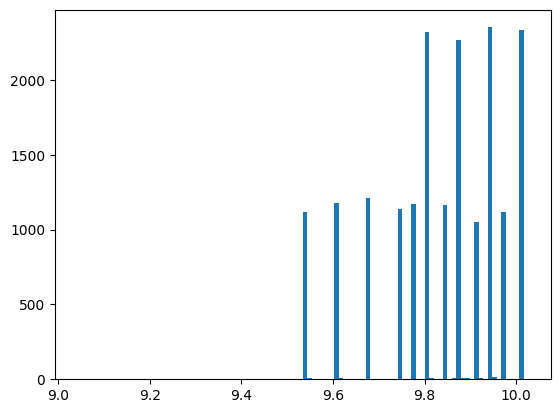

In [222]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.hist(video_clip_duration_list, bins=100)

In [23]:
# pd.DataFrame(pass_event_row_list).columns
new_pass_df = pd.DataFrame(pass_event_row_list)
# Rearange column to put clipfile in front of video file
new_pass_df = new_pass_df.reindex(columns=['pass_id', 'riderid', 'tripnumber', 'clipfile', 'videofile', 'frameminutes',
                                           'milliseconds', 'passdistance', 'buttonpress', 'timestamp', 'latitude',
                                           'longitude', 'vehicle_coded', 'location_coded', 'bikelane_coded',
                                           'parkedcar_coded', 'eventtype_coded', 'sign_speed', 'miss_signspeed',
                                           'passdistance_coded', 'passdistance_1m', 'speedzone_coded', 'speedzone_collapsed'])
new_pass_df.to_csv('OpenSource_PassingDistanceData.csv',index=False)

In [24]:
# # Rename video clip if video clip is not named with padding 0 (padding 0 to make it easier to video in file browser in order)
# for clip_name in os.listdir(passing_event_dir):
#     clip_id = "{:06}".format(int(clip_name.split('_')[-1].split('.')[0]))
#     new_clip_name = 'PassingEvent_Duration10s_{}.mp4'.format(clip_id)
#     print(new_clip_name)
#     os.rename(os.path.join(passing_event_dir, clip_name), os.path.join(passing_event_dir, new_clip_name))

In [25]:
Pass_df['pass_id'].values.max()

18650